Pruebas en el modelo v6

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

import os

import torch
import torch.utils.data
from opts import opts
from models.model import create_model, load_model, save_model
from models.data_parallel import DataParallel
from logger import Logger
from datasets.dataset_factory import get_dataset
from trains.train_factory import train_factory
import cv2
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from detectors.detector_factory import detector_factory

image_ext = ['jpg', 'jpeg', 'png', 'webp']
video_ext = ['mp4', 'mov', 'avi', 'mkv']
time_stats = ['tot', 'load', 'pre', 'net', 'dec', 'post', 'merge']

In [2]:
sys.argv = ['-f', 'ctdetv2', '--demo', '../images/yolo/', '--arch','dlav6_34',  '--load_model' ,'../exp/ctdetv2/coco_dlav6/model_last.pth'] #cmd = 'ctdet --exp_id coco_dla --batch_size 4 --lr 1.25e-4  --gpus 0 --num_workers 0'
opt = opts().parse()
print(opt.task)

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  C:\Users\avata\FewShot-CenterNet\src\lib\..\..\exp\ctdetv2\default
ctdetv2


In [3]:
opt = opts().init()

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  C:\Users\avata\FewShot-CenterNet\src\lib\..\..\exp\ctdetv2\default
heads {'hm': 80, 'wh': 2, 'reg': 2}


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str
#opt.debug = max(opt.debug, 1)
opt.debug = 0
Detector = detector_factory[opt.task]
detector = Detector(opt)

Creating model...
loaded ../exp/ctdetv2/coco_dlav6/model_last.pth, epoch 240


In [5]:
detector.model

DLASeg(
  (base): DLA(
    (base_layer): Sequential(
      (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (level0): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (level1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (level2): Tree(
      (tree1): BasicBlock(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [6]:
image_names = [opt.demo]
#image_names.append('../images/Perro1.jpg')
"""
image_names.append('../images/aceite_4.png')
image_names.append('../images/cubix_0.png')
image_names.append('../images/cubix_5.png')
image_names.append('../images/te_0.png')
image_names.append('../images/te_8.png')
"""
image_names = []
ls = os.listdir(opt.demo)
for file_name in sorted(ls):
  ext = file_name[file_name.rfind('.') + 1:].lower()
  if ext in image_ext:
      image_names.append(os.path.join(opt.demo, file_name))
print(image_names)

['../images/yolo/aceite_0.png', '../images/yolo/aceite_4.png', '../images/yolo/aerosol_0.png', '../images/yolo/aerosol_4.png', '../images/yolo/azucarero_0.png', '../images/yolo/azucarero_4.png', '../images/yolo/balsamo_0.png', '../images/yolo/balsamo_4.png', '../images/yolo/borrador_0.png', '../images/yolo/borrador_4.png', '../images/yolo/cafe_0.png', '../images/yolo/cafe_5.png', '../images/yolo/cera_0.png', '../images/yolo/cera_4.png', '../images/yolo/coca_0.png', '../images/yolo/coca_5.png', '../images/yolo/colador_0.png', '../images/yolo/colador_5.png', '../images/yolo/cubix_0.png', '../images/yolo/cubix_5.png', '../images/yolo/leche_4.png', '../images/yolo/leche_8.png', '../images/yolo/pelota_0.png', '../images/yolo/pelota_3.png', '../images/yolo/te_0.png', '../images/yolo/te_8.png']


In [102]:
descriptores = {}
descriptores2 = {}
m = torch.nn.ReLU()
for (image_name) in image_names:
    print(image_name)
    ret = detector.run(image_name)
    output = ret['output']
    pred_obj = output['objns']
    hm = pred_obj.squeeze(0).squeeze(0)
    scores = output['hm'].squeeze(0)
    batch, cat, height, width = pred_obj.size()
    topk_scores, topk_inds = torch.topk(pred_obj.view(batch, cat, -1), 1)
    print(topk_scores)
    print(topk_inds)

    topk_inds = topk_inds % (height * width)
    topk_ys   = (topk_inds / width).int()
    topk_xs   = (topk_inds % width).int()
    print(topk_ys[0,0,0])
    print(topk_xs[0,0,0])
    print(hm[topk_ys[0,0,0],topk_xs[0,0,0]])
    print(hm[62,64])
    print(max(scores[:,topk_ys[0,0,0],topk_xs[0,0,0]]))
    #descriptores[image_name] = output['descriptor'].squeeze(0)[:,int(topk_xs),int(topk_ys)]
    radio = 5
    
    eje_x, eje_y = int(topk_xs), int(topk_ys)
    
    if not (eje_x>66) or not (eje_x<58):
        eje_x = 62
    
    if not (eje_y>66) or not (eje_y<58):
        eje_y = 64
        
    
    
    descriptores[image_name] = output['descriptor'].squeeze(0)[:,eje_x,eje_y]
    count = 1
    for x in range(eje_x - radio, eje_x + radio+1):
        for y in range(eje_y - radio, eje_y + radio+1):
            if not (x==eje_x and y==eje_y):
                descriptores[image_name] = (descriptores[image_name]+output['descriptor'].squeeze(0)[:,x,y])
                count += 1
    descriptores[image_name] = descriptores[image_name]/count
    descriptores2[image_name] = output['descriptor2'].squeeze(0)[:,int(topk_xs),int(topk_ys)]
    
    print(output['wh'][0,0,62,64])
    print(output['wh'][0,1,62,64])
    print('-------------------------')

../images/yolo/aceite_0.png
tensor([[[0.9129]]], device='cuda:0')
tensor([[[8128]]], device='cuda:0')
tensor(63, device='cuda:0', dtype=torch.int32)
tensor(64, device='cuda:0', dtype=torch.int32)
tensor(0.9129, device='cuda:0')
tensor(0.8214, device='cuda:0')
tensor(0.2353, device='cuda:0')
tensor(53.0402, device='cuda:0')
tensor(112.7295, device='cuda:0')
-------------------------
../images/yolo/aceite_4.png
tensor([[[0.9636]]], device='cuda:0')
tensor([[[8511]]], device='cuda:0')
tensor(66, device='cuda:0', dtype=torch.int32)
tensor(63, device='cuda:0', dtype=torch.int32)
tensor(0.9636, device='cuda:0')
tensor(0.4867, device='cuda:0')
tensor(0.3390, device='cuda:0')
tensor(51.1768, device='cuda:0')
tensor(114.1853, device='cuda:0')
-------------------------
../images/yolo/aerosol_0.png
tensor([[[0.9983]]], device='cuda:0')
tensor([[[7744]]], device='cuda:0')
tensor(60, device='cuda:0', dtype=torch.int32)
tensor(64, device='cuda:0', dtype=torch.int32)
tensor(0.9983, device='cuda:0')
t

tensor([[[8383]]], device='cuda:0')
tensor(65, device='cuda:0', dtype=torch.int32)
tensor(63, device='cuda:0', dtype=torch.int32)
tensor(0.9710, device='cuda:0')
tensor(0.8399, device='cuda:0')
tensor(0.1452, device='cuda:0')
tensor(100.3275, device='cuda:0')
tensor(89.1196, device='cuda:0')
-------------------------
../images/yolo/te_8.png
tensor([[[0.9999]]], device='cuda:0')
tensor([[[8256]]], device='cuda:0')
tensor(64, device='cuda:0', dtype=torch.int32)
tensor(64, device='cuda:0', dtype=torch.int32)
tensor(0.9999, device='cuda:0')
tensor(0.9781, device='cuda:0')
tensor(0.1941, device='cuda:0')
tensor(91.1365, device='cuda:0')
tensor(105.0985, device='cuda:0')
-------------------------


In [67]:
hm[64,64]

tensor(0.9999, device='cuda:0')

In [68]:
output['wh'][0,0,62,64]

tensor(91.1365, device='cuda:0')

In [69]:
from torch.nn.functional import normalize
import numpy as np

In [103]:
def cosdis(x,y):
    x = x.unsqueeze(0)
    y = y.unsqueeze(1)
    x_n = normalize(x,dim=1)
    y_n = normalize(y,dim=0)
    return x_n@y_n

In [104]:
D = []
for i in range(len(image_names)):
    D.append(descriptores[image_names[i]])

In [105]:
matrix = torch.zeros((len(image_names),len(image_names)))
for i in range(len(image_names)):
    for j in range(len(image_names)):
        score = cosdis(D[i],D[j])[0,0]
        matrix[i,j]=score  
    
np_matrix = np.array(matrix)

In [106]:
image_names_ext = [n[n.rfind('/')+1:n.rfind('_')] for n in image_names]
image_names_ext2 = [n[n.rfind('/')+1:n.rfind('.')] for n in image_names]

In [107]:
for i in range(len(image_names)):
    for j in range(len(image_names)):
        if i==j:
            matrix[i,j]=0

In [108]:
fallos = []
aciertos = []

count = 0
for i in range(len(image_names)):
    if image_names_ext[i] == image_names_ext[int(matrix[i].argmax())]:
        aciertos.append(image_names_ext2[i]+'|'+image_names_ext2[int(matrix[i].argmax())])
        count+=1
    else:
        fallos.append(image_names_ext2[i]+'|'+image_names_ext2[int(matrix[i].argmax())])      
        
        
acc = count/len(image_names)

In [109]:
fallos

['aceite_0|aerosol_0',
 'cera_0|aceite_0',
 'cera_4|balsamo_4',
 'te_0|leche_4',
 'te_8|leche_8']

In [110]:
aciertos

['aceite_4|aceite_0',
 'aerosol_0|aerosol_4',
 'aerosol_4|aerosol_0',
 'azucarero_0|azucarero_4',
 'azucarero_4|azucarero_0',
 'balsamo_0|balsamo_4',
 'balsamo_4|balsamo_0',
 'borrador_0|borrador_4',
 'borrador_4|borrador_0',
 'cafe_0|cafe_5',
 'cafe_5|cafe_0',
 'coca_0|coca_5',
 'coca_5|coca_0',
 'colador_0|colador_5',
 'colador_5|colador_0',
 'cubix_0|cubix_5',
 'cubix_5|cubix_0',
 'leche_4|leche_8',
 'leche_8|leche_4',
 'pelota_0|pelota_3',
 'pelota_3|pelota_0']

In [111]:
print(acc)

0.8076923076923077


EUC DIST

In [19]:
from torch.nn.functional import normalize
import numpy as np

In [20]:
def eucdis(x,y):
    return torch.sqrt(torch.sum((x-y)**2))

In [21]:
D = []
for i in range(len(image_names)):
    D.append(descriptores[image_names[i]])

In [22]:
matrix = torch.zeros((len(image_names),len(image_names)))
for i in range(len(image_names)):
    for j in range(len(image_names)):
        score = eucdis(D[i],D[j])
        matrix[i,j]=score  
    
np_matrix = np.array(matrix)

In [23]:
for i in range(len(image_names)):
    for j in range(len(image_names)):
        if i==j:
            matrix[i,j]=99999999999

In [24]:
image_names_ext = [n[n.rfind('/')+1:n.rfind('_')] for n in image_names]
image_names_ext2 = [n[n.rfind('/')+1:n.rfind('.')] for n in image_names]
fallos = []
aciertos = []

count = 0
for i in range(len(image_names)):
    if image_names_ext[i] == image_names_ext[int(matrix[i].argmin())]:
        aciertos.append(image_names_ext2[i]+'|'+image_names_ext2[int(matrix[i].argmin())])
        count+=1
    else:
        fallos.append(image_names_ext2[i]+'|'+image_names_ext2[int(matrix[i].argmin())])      
        
        
acc = count/len(image_names)

In [25]:
aciertos

['aceite_0|aceite_4',
 'aceite_4|aceite_0',
 'aerosol_0|aerosol_4',
 'aerosol_4|aerosol_0',
 'azucarero_0|azucarero_4',
 'azucarero_4|azucarero_0',
 'balsamo_0|balsamo_4',
 'borrador_0|borrador_4',
 'borrador_4|borrador_0',
 'cafe_0|cafe_5',
 'cafe_5|cafe_0',
 'coca_0|coca_5',
 'coca_5|coca_0',
 'colador_0|colador_5',
 'colador_5|colador_0',
 'cubix_0|cubix_5',
 'cubix_5|cubix_0',
 'leche_4|leche_8',
 'leche_8|leche_4',
 'pelota_0|pelota_3',
 'pelota_3|pelota_0']

In [26]:
fallos

['balsamo_4|cera_4',
 'cera_0|aceite_0',
 'cera_4|balsamo_4',
 'te_0|leche_4',
 'te_8|leche_4']

In [40]:
print(acc)

0.8076923076923077


ASDASD

In [41]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

<AxesSubplot:>

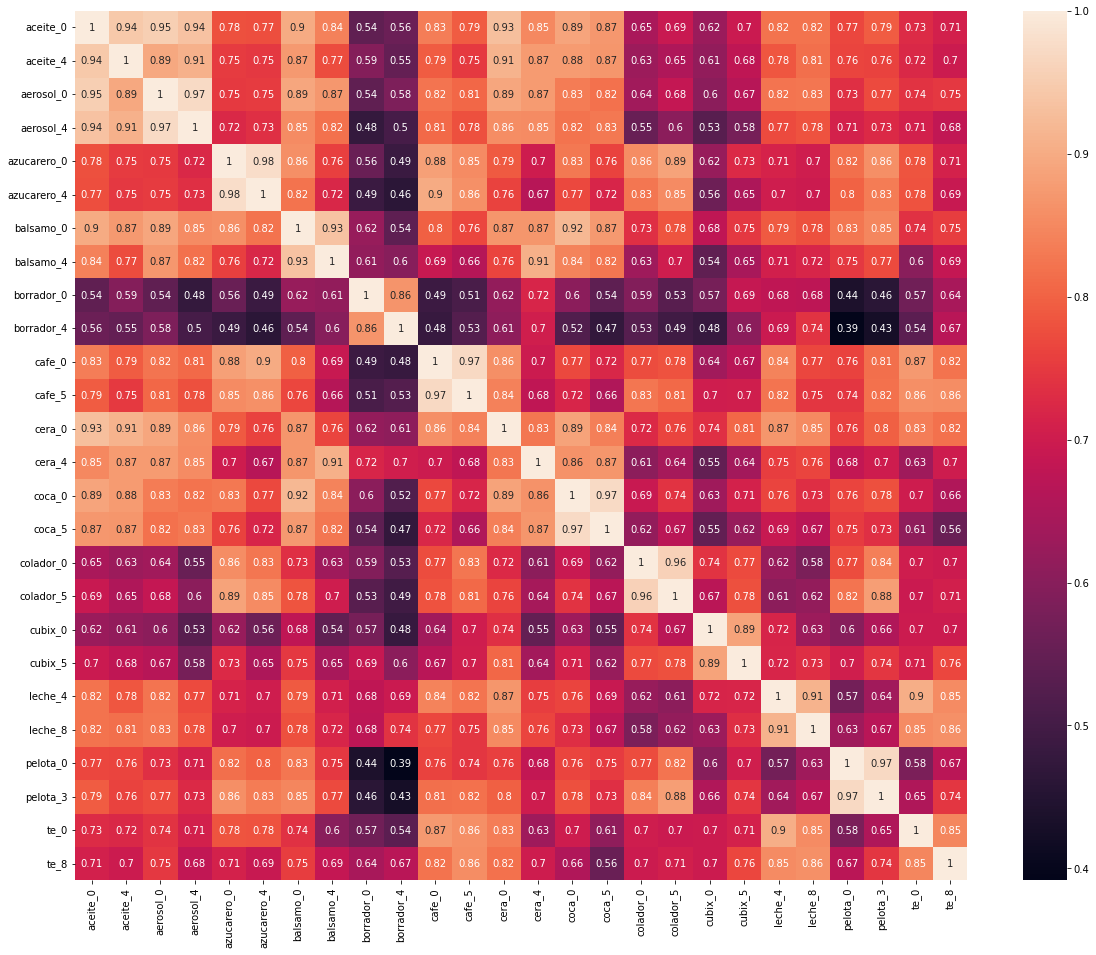

In [101]:
df_cm = pd.DataFrame(np_matrix, index = [i for i in image_names_ext2],
                  columns = [i for i in image_names_ext2])
plt.figure(figsize = (20,16))
sn.heatmap(df_cm, annot=True)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Supongamos que Emb_aceite_frente, Emb_aceite_arriba y Emb_aceite_atras son tus embeddings
# y cada uno tiene una forma (256,).

# Convertir los embeddings a tensores de PyTorch
Emb_aceite_frente = torch.tensor(Emb_aceite_frente, dtype=torch.float32)
Emb_aceite_arriba = torch.tensor(Emb_aceite_arriba, dtype=torch.float32)
Emb_aceite_atras = torch.tensor(Emb_aceite_atras, dtype=torch.float32)

# Definir la arquitectura de la red
class CombiningModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CombiningModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Configurar el modelo
input_size = 256
hidden_size = 128
output_size = 256

model = CombiningModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()  # Mean Squared Error como función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
inputs = torch.stack([Emb_aceite_frente, Emb_aceite_arriba, Emb_aceite_atras])
target_output = Emb_aceite_frente.clone().detach()  # Usar uno de los embeddings como referencia

for epoch in range(50):
    optimizer.zero_grad()
    output = model(inputs)
    loss = criterion(output, target_output)
    loss.backward()
    optimizer.step()

# Obtener el embedding combinado
combined_embedding = model(inputs)
